<table>
 <tr align=left><td><img align=left src="../images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [1]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

## My First Notebook Test
This is a **Markdown** cell. I can write notes, math like $e^x$ or instructions here.

In [2]:
import sys
print(sys.executable)

/Users/mpm/anaconda3/envs/apma4300/bin/python


In [2]:
2 * 2

4

In [ ]:
print(0.1)

0.1


Note to lecturers:  This notebook is designed to work best as a classic Jupyter Notebook with nbextensions 
* hide_input: to hide selected python cells particularly for just plotting
* RISE:  Interactive js slide presentations

# Introduction to Numerical Methods

## Outline

* Introduction and Motivation
* Some examples of Numerical Problems
* Overview of Course materials
* Course Logistics
* <font color=red>**Prerequisites and "Fluency"**</font>
* Overview of the course computational environment (Python, jupyter, git)
* Getting started...

## What are Numerical Methods?

* An extremely broad field -- much broader than this class

* Rough <font color=red>definition</font>:  analysis and application of algorithms to allow computers to solve problems in math, science, engineering...

* Strictly speaking, numerical methods don't require computers (e.g. Newton's method is ~ 17 century)

* But computers make things practical...Consider this class an introduction to computational math

## Why do we need numerical methods?

### Some problems have <font color=red>**no closed form solution** </font>
    
   Example:  find $f(x)=0$ for the 5th order polynomial
    
$$
    x^5 + 3x^2+ 2x + 3 = 0
$$

$$
    p(x) = x^5 + 3x^2+ 2x + 3 = 0
$$

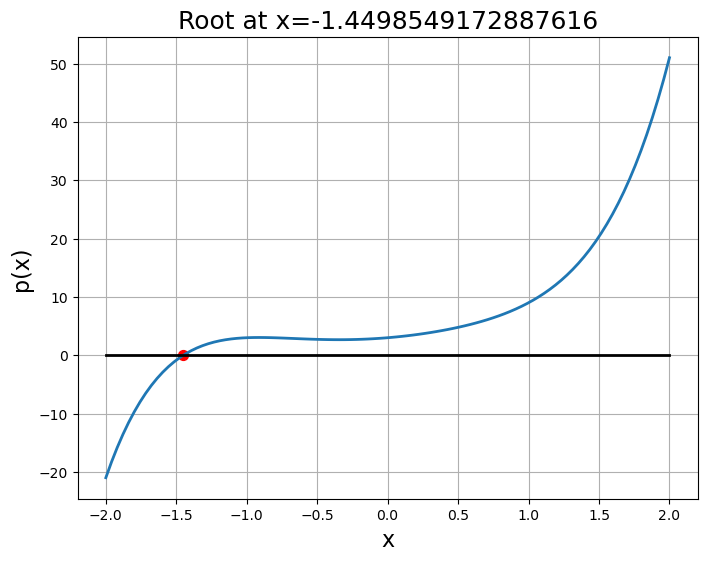

In [3]:
p = lambda x:  x**5 +3*x**2 +2*x +3

from scipy.optimize import brentq

x = numpy.linspace(-2,2,100)
x0 = brentq(p,-2,2)

plt.figure(figsize=(8,6))
plt.plot(x,p(x),linewidth=2)
plt.plot(x,numpy.zeros(x.shape),'k',linewidth=2)
plt.scatter(x0,p(x0),s=50,c='r')
plt.grid()
plt.xlabel('x',fontsize=16)
plt.ylabel('p(x)',fontsize=16)
plt.title('Root at x={}'.format(x0),fontsize=18)
plt.show()

The 5th order polynomial  $p(x) = x^5 + 3x^2+ 2x + 3 = 0$ actually has 5 complex roots

In [ ]:
c = [1,0,0,3,2,3]
roots = numpy.roots(c)
fig = plt.figure(figsize=(8,6))
plt.scatter(numpy.real(roots),numpy.imag(roots),s=50,c='r')
x=numpy.linspace(-2,2)
plt.plot(x,numpy.zeros(x.shape),'k',linewidth=2)
plt.plot(numpy.zeros(x.shape),x,'k',linewidth=2)

plt.xlabel('Re',fontsize=16)
plt.ylabel('Im',fontsize=16)
plt.grid()
plt.title('Complex roots of a 5th order polynomial')
plt.axis('square')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

which require completely different numerical methods to find.

In general, the roots of most nonlinear systems,
    
$$
    \mathbf{F}(x,y,z,t) = \mathbf{0},
$$
    
cannot be solved directly.


### Some problems are too big to be done by hand. 

It may not possible to calculate an exact answer in a convenient amount of time.  E.g. Large linear systems (with exact solutions) occur in many problems, but require $O(N^3)$ operations.

<table style="width:50%">
  <tr>
     <img src="../images/linear_regression.png" width="900"/>
  </tr>
</table>

### Some problems are simply not analytic

#### Data analysis of digital data

Finding trends in real data represented without a closed form (analytical form).


In [7]:
data = numpy.loadtxt("./data/sunspot.dat")

fig = plt.figure(figsize=(10, 5))
fig.set_figwidth(fig.get_figwidth() * 2)

axes = fig.add_subplot(1, 2, 1)
axes.plot(data[:, 0], data[:, 1],linewidth=2)
axes.set_xlabel("Year",fontsize=16)
axes.set_ylabel("Number",fontsize=16)
axes.set_title("Number of Sunspots",fontsize=18)

axes = fig.add_subplot(1, 2, 2)
N = int(data.shape[0] / 2)
period = 1.0 / numpy.fft.fftfreq(data.shape[0])[1:N]
sunspot_freq = numpy.fft.fft(data[:, 1])[1:N]
freq = numpy.fft.fftfreq(data.shape[0])[1:N]
axes.plot(period, numpy.abs(sunspot_freq)**2,linewidth=2)
axes.set_xlabel("Years/Cycle",fontsize=16)
axes.set_ylabel("Power Spectrum",fontsize=16)
axes.set_title("Frequency of Sunspots",fontsize=18)
axes.set_xlim((0, 50))

plt.show()

FileNotFoundError: ./data/sunspot.dat not found.

### Sometimes you actually want an answer 

(rather than show it exists or is unique)

##### Example:  Solution of non-linear dynamical systems

$$
    \frac{d\mathbf{u}}{dt} = \mathbf{F}(t,\mathbf{u}),\quad \mathbf{u}(0)=\mathbf{u}_0
$$

* Can prove that if $\mathbf{F}$ is sufficiently smooth (Lipshitz Continuous) over some domain that a unique solution exists for some local interval in time (Picard-Lindelhof Theorem)
* However, the theorem provides <font color=red>**no**</font> way to  efficiently find a solution

### Example: A non-linear  model of Epidemics

Classical [Kermack and McKendrick (1927)](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118) SIR model of epidemics (with reinfection)

$$
\begin{align}
    \frac{ds}{dt} &= -si + kr \\
    \frac{di}{dt} &= si -\sigma i \\
    \frac{dr}{dt} &= \sigma i - kr\\
\end{align}
$$

Where the variable $s$ represents the fraction of a population that is **Susceptible** to infection, $i$ is the proportion **Infected** and $r$ the fraction **Recovered**.  For this model $s+i+r =1$.  The parameters $\sigma, k \geq 0$ control the relative rates of infection and recovery.  

$$
\begin{align}
    \dot{s} &= -si + kr \\
    \dot{i} &= si -\sigma i \\
    \dot{r} &= \sigma i - kr\\
\end{align}
$$

In [ ]:
# Solve using SciPy's ODE integrator solve_ivp
from scipy.integrate import  solve_ivp

# define the RHS of our system of ODE's
def sir(t, u, sigma, k):
    s,i,r = u
    return numpy.array([-s*i + k*r,
                        (s - sigma)*i,
                        sigma*i - k*r ])



### Numerical Solutions 

In [ ]:
sigma = .5
k = 0.025
t_max = 200
sir_0 = [0.999, 0.001, 0.]
sol = solve_ivp(sir, [0, t_max] , sir_0, args=(sigma, k), rtol=1.e-6, atol=1.e-9,dense_output = True)

In [ ]:
t = numpy.linspace(0, t_max, 300)
z = sol.sol(t)

fig = plt.figure(figsize=(20,7))
axes = fig.add_subplot(1,2,1)
axes.plot(t,z[0],'r',label='s', linewidth=2)
axes.plot(t,z[1],'b',label='i', linewidth=2)
axes.plot(t,z[2],'g',label='r',  linewidth=2)
axes.plot(t,sigma*numpy.ones(t.shape),'k--',label='$\sigma$')

axes.legend(loc='best',shadow=True, fontsize=14)
axes.set_xlabel('Time',fontsize=16)
axes.set_ylabel('Population fraction',fontsize=16)
axes.grid()
axes.set_title('SIR system: $\sigma={}$, $k={}$'.format(sigma,k),fontsize=18)
plt.show()

### Questions an epidemiologist or a mathematician might ask:
 - Does this solution admit steady states?
 - Under what conditions is this problem stable, unstable, oscillatory?
 - How do we solve the initial value problem?
 - How do we understand the non-linear dynamics?
 - What impacts do small changes to the different parameters have?
 - How do we estimate parameters ($\sigma$, $k$) from data?
 - How do we evaluate whether this is a *good* model?

### Big Points

* Numerics <font color=red>**complement** </font> analytic methods, but don't replace them
    
* You need both to <font color=red> **understand** </font> your problems

* Numerical methods are only a part of the bigger problem of <font color=red>**Mathematical Modeling**</font>


## Mathematical Modeling

<table style=width:100%>
    <tr>
        <th></th>
        <th><img src="../images/mathModeling.png" width="800"/><th>
    </tr>
</table>



* Murphy was a modeler...

* You need to understand **all** the aspects of the problem...

* Strictly speaking this is not a course in Mathematical Modeling

We usually have experience and insights into a system and have a good idea what the solutions should be. At the same time the numerics can help us build our intuition and complement analytical methods. The numerics can also be used to test ideas and extend our understanding of a system. In doing so we can update mathematical descriptions to account for new aspects.

The process of describing physical systems using mathematical expressions is often referred to as mathematical modeling. It is a process in which intuition, simulation, and analysis are used to build expressions that mimic general behaviours of physical systems. The general practice is to start with a basic description and refine it over many iterations. 

Each step in the process introduces error. In this course we will focus on the errors associated with numerical approximation. It is important, though, to be able to determine the difference between errors associated with simplifications associated with the model and the errors associated with the approximation of mathematical expressions.

## Why is this exciting?

Computers have revolutionized our ability to explore...

[Top 10 Algorithms of the 20th Century](http://www.siam.org/pdf/news/637.pdf?t=1&cn=ZmxleGlibGVfcmVjcw%3D%3D&refsrc=email&iid=658bdab6af614c83a8df1f8e02035eae&uid=755271476&nid=244+285282312)

...and there is more to come!

## The issues:
### Accuracy and Efficiency

- Numerical methods, invariably include an enormous range of <font color=red> approximations </font>, each with attendant <font color=red> errors </font>

- Good numerical methods also return error estimates, and are stable in the presence of floating point error

- The detailed analysis of algorithms and their errors is formally <font color=red> Numerical Analysis </font>

## <font color=red> **This is not a class in numerical analysis** </font>

This is principally a Methods class where I will emphasize

- Standard Methods and their errors
- Give insight into how they work (and when they don't)
- Give you practice implementing them to solve **your** problems
- Point you to high quality numerical software that you should be using in your own work
- <font color=red> Help you make good choices <font>


<table style=width:100%>
    <tr>
<img src="../images/MakeGoodChoices.gif" width="800"/>
    </tr>
</table>




<table style=width:100%>
    <tr>
<img src="../images/RuiningMyLife.gif" width="800"/>
    </tr>
</table>



## Course Content

Topics Covered: (see Syllabus on [Courseworks](https://courseworks2.columbia.edu/courses/191992/assignments/syllabus))

- Quick <font color=red>*Review*</font> of computational Tools (Python,numpy,matplotlib,scipy,git)
- Sources of Error and Error Analysis
- Rootfinding/Optimization of non-linear functions $f(x)$ 
- Interpolation
- Numerical integration (quadrature) and differentiation
- Solution of ODE Initial value problems
- Solving <font color=red> systems </font> of non-linear equations $\mathbf{F}(\mathbf{x})=\mathbf{0}$
- ODE 2-point Boundary value problems (towards numerical PDE's)
- Numerical Linear Algebra


### Topics Not Covered: 

- Optimization -- linear programming, constrained optimization
- Numerical Solution of PDE's (APMA E4301)
- Mathematical Modeling (maybe a little)
- Machine Learning/Data Science (Lots of other courses)
- Lot's of things that would be fun...


## Purpose of this course:

Choose and understand critical methods that are essential for Numerical PDE's, modeling and scientific computation.


<table style="width:100%">
  <tr>
    <th><img src="../images/siemens-volrender0000_kirby_modeling.png" width="500"/></th>
    <th><img src="../images/Fenics_tc_vm.png" width="500"/></th> 
  </tr>
    <td align=center>HPC model of Windturbine turbulence by <a href=http://students.uwyo.edu/akirby/>Andrew Kirby</a></th>
    <td align=center><a href=http://fenicsproject.org>FEniCS</a> FEM model of a turbocharger</th>
</table>

## Some FEM Magma Dynamics models (from Spiegelman)



Choose and understand critical methods that are essential for Numerical PDE's, modeling and scientific computation.


<table style="width:120%">
  <tr>
    <th align="center"><img src="../images/TerraFERMAExamples.jpg" width="1000" align="center"/></th>
  </tr>
</table>

### A FEM model from Spiegelman

Coupled fluid/solid dynamics model of magmatism in the Earth's mantle.

In [ ]:
from IPython.lib.display import YouTubeVideo
vid = YouTubeVideo('Pfp4snvqhus',rel=0,width=700,height=450, loop=1)
display(vid)

### All of these problems require <font color=red>Interpolation, numerical quadrature,numerical linear algebra </font>,

#### Plus PDE's, Vector Calculus, functional analysis,computational geometry, C++/Python programming

## Course Logistics

- 2 Lectures per week (recorded for CVN, makeups)
- Office Hours
- 8 Problem sets (50\%)
- Final Project (50\%)

- No primary text but
- All notes available as Jupyter notebooks through github

## Course Pre-requisites

### Numerical methods aren't particularly hard...

* however...They require significant <font color=red> **fluency** </font> in
    * Calculus
    * Vector Calculus
    * ODE's
    * Linear Algebra
    * Programming: Python 3 (numpy, matplotlib, scipy)

#### Please fill out the [User Survey](https://forms.gle/ARGPHcZB6pFsAh4v5) if you haven't already

#### The Objective: Computational Fluency 

- the ability to:
    - move smoothly between continous and discrete problems
    - recognize and use a range of mathematical/computational techniques
    - use best practices for software development 
    - keep track of errors and artifacts
    - stay on top of complex, multi-part problems
    - <font color=red>**Debug**</font> and <font color=red>**Test**</font>

- All are required to formulate, solve, and **understand** problems of your own choosing

- Anything that can go wrong...will go wrong

## The Elephant in the Room: Generative AI

<table style="width:50%">
  <tr>
     <img src="../images/ChatGPT-elephant-in-the-room.png" width="900"/>
  </tr>
</table>

## The Elephant in the Room: Generative AI

<table style="width:50%">
  <tr>
     <img src="../images/ChatGPT-elephant-in-the-room-giant-keyboard-monitor.jpg" width="900"/>
  </tr>
</table>

## Comments and Questions

* The goal of education and research is *deep* knowledge



* Hard work is hard...



* Does Generative AI help us do hard things better?



* Or does it make us lazy?



## Possible Futures?




this...

<table style="width:50%">
  <tr>
     <img src="../images/AI_future_WallE.png" width="900"/>
  </tr>
</table>

or this...

<table style="width:50%">
  <tr>
     <img src="../images/AI_future_terminator.png" width="900"/>
  </tr>
</table>

or this...

<table style="width:50%">
  <tr>
     <img src="../images/AI_future_BlackPanther.png" width="900"/>
  </tr>
</table>

## The Answer is not obvious...

And the terraine is shifting rapidly...


#### Some Initial Data

[Becker, J., Rush, N., Barnes, E., Rein, D., 2025](https://doi.org/10.48550/arXiv.2507.09089)

<table style="width:100%">
  <tr>
      <th><img src="../images/Becker_et_al_2025_title.png" width="500"/></th>
      <th><img src="../images/Becker_et_al_2025_fig1.png" width="500"/></th>

  </tr>
</table>

#### Additional Insights

<table style="width:100%">
  <tr>
      <th><img src="../images/Becker_et_al_2025_fig3.png" width="500"/></th>
      <th><img src="../images/Becker_et_al_2025_fig6.png" width="500"/></th>

  </tr>
</table>

## An Experiment:  4300 AI Policy

* I will be agnostic about the use and/or utility of AI
* But I expect you to be honest and tell me
    * If and how you use it
    * If it is useful for your work
    * Does it actually improve your understanding of the work?




* For every assignment you must complete a brief [AI use survey](https://forms.gle/TyU7xVqTpr8ATeXi8) 
* **No Credit will be given without an accompanying survey**
* Anonymized responses will be reported back to the class


## Computational Tools/Environment

### Computer Languages

* Compiled languages: C, C++, Fortran
* Commercial interactive modeling systems: Matlab, Mathematical, IDL
* Open-source interpreted languages: Python, R, Julia, Ruby

#### C, C++, Fortran

##### Pros:
 - Performance and legacy computing codes available

##### Cons:
 - Syntax not optimized for casual programming
 - No interactive facilities
 - Difficult visualization, text processing, etc.
 

#### IDL, Matlab, Mathematica, etc.

##### Pros:
 - Interactive with easy visualization tools
 - Extensive scientific and engineering libraries available

##### Cons:
 - Costly and proprietary
 - Unpleasant for large-scale computing and non-mathematical tasks

### Python (3.x)

##### Features and Project Goals:
 - Python is free (BSD-like license) and highly portable (Windows, Mac OS X, Linux, etc.)
 - Interactive interpreter
 - Readability
 - Simple
 - Extensive documentation
 - Memory management is (mostly) transparent
 - Clean and object-oriented
 - Built-in types

##### Pros:
- Comprehensive standard library
 - Well-established 3rd-party packages (NumPy, SciPy, matplotlib, etc.)
 - Easily wraps existing legacy code in C, C++ and Fortran
 - Python mastery is marketable
 - Scalability
   - Interactive experimentation
   - Good tools for documenting code, and the resulting code tends to be easier to maintain compared to other interpreted languages.
   - Code can be one-line scripts or million-line projects
   - Used by novices and full-time professionals alike

##### Cons:
 - Can be slow
 - Packaging system is a bit crufty
 - Discipline is forced on the programmer by the design of the language. Can limit choices available for how to implement an algorithm. (The *python* way.)
 

### Version Control via `git`

`git` is version control system allowing a user to take "snapshots" of data.  These snapshots can then be compared, combined or recalled as needed.

Why version control (or `git`)?
 - Nearly ubiquitous in modern software engineering and hence an essential skill
 - Can save you from yourself
 - Greatly simplifies the way multiple people can work on and share a single project.
 - Steep learning curve so expose yourself often for maximal success
 
[Learn more!](https://git-scm.com/)

### Jupyter Notebooks

The notebook environment gives us a convenient means for working with code while annotating it.  We will only cover the key concepts here and hope that you will explore on your own the environments.

[Documentation](https://jupyter.readthedocs.io/en/latest/)

#### Toolbar

 - Notebooks are modal, they have an edit mode (editing cells) and command mode.
 - Highly recommend taking the tour and checking out the help menu 

#### Content types
   - Markdown
   - $\LaTeX$ -- $x^2 + y^2 = \sin(x)$
   - Python
   - NumPy, SciPy, and other packages
   - Other languages (R, Julia)

### Running the Notebooks

To run and interact with the notebooks you need the Jupyter software and scipy software stack

#### Interactive Environments -- all web-based

* Jupyter Lab
* Classical Jupyter Notebook
* Presentation modes (e.g. RISE)

#### Standard Scipy software stack
* Python 3.x
* SciPy
* Numpy
* Matplotlib
* Sympy
* Pandas
* etc 

### Installations: A few options

#### Install on your <font color=red>own machine </font>
 - [Anaconda](http://anaconda.com/downloads)
 - [Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/index.html)
 


#### The "cloud"

Instead of running things locally on your machine there are a number of cloud services that you are welcome to use in order to get everything running easily:
 - [Google's Colaboratory](https://colab.research.google.com)
 - [Microsoft Azure Notebooks](https://notebooks.azure.com)
 - [CoCalc](https://cocalc.com/)
 - Columbia's CUIT Jupyter Hub server (when available)


### Obtaining the Notebooks

All notebooks can be  found on [github](http://github.com/mspieg/intro-numerical-methods).

It is highly recommended to  obtain a github account if you do not already have one.  Will allow you start to become comfortable with `git`.  

If you want to work directly with the repository,  make your own personal fork,  and keep track of any changes and submit issues to the github project page if you find mistakes (PLEASE DO THIS!).  It will be much easier to do so if you have your own account on github and work with your own clone. You can then submit a merge request to have your changes incorporated into other repositories.

### However...

`git` and `jupyter` don't always play that well together so some care needs to be taken to keep my changes and your changes in sync.  

To alleviate this problem, we will use [`nbgitpuller`](https://jupyterhub.github.io/nbgitpuller/) to try and keep my notes and yours up-to-date.

Simply log in to your Jupyter Hub Account through this [link](https://apma4300.columbiajupyter2.org/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fmspieg%2Fintro-numerical-methods&urlpath=lab) which will automatically update the notebooks with any of my recent changes while preserving your work.

The nbgitpuller link is also available through Courseworks. 

**Warning**:  this doesn't always work, but if it breaks I'll help you fix it


###  Let's take a little time to make sure everything is working...

### Peer Review

**Why?**
In this class reviewing your peer's work can lead to
 - Better understanding of a problem
 - See alternative solutions to the same problem
 - Learn how to read other people's code
 - Hopefully learn some tips about your own coding style
 - Another skill highly used in practice
 - Demonstrate why readibility and discipline with respect to code matters.